<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/adv_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mnist
!pip install jax jaxlib --upgrade
!pip install -q git+https://www.github.com/google/neural-tangents

Requirement already up-to-date: jax in /usr/local/lib/python3.6/dist-packages (0.2.5)
Requirement already up-to-date: jaxlib in /usr/local/lib/python3.6/dist-packages (0.1.57)


In [ ]:
import pathlib
import random
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import jax
import jax.numpy as jnp
import functools
import copy
import numpy as np
import requests
import pickle
import tarfile
import tensorflow as tf
import tensorflow_datasets as tfds
import operator
import math

from sklearn import svm
from scipy.ndimage import interpolation

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax

In [ ]:
def downsample_imgs(imgs, image_width):
  return tf.image.resize(
    tf.convert_to_tensor(imgs),
    size=[image_width, image_width],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=True,
    antialias=False,
  ).numpy()

def get_np_data(
  name, # "mnist" or "cifar10"
  split,
  binary_labels=False,
  image_width=None):
  xs, ys = operator.itemgetter("image", "label")(
    tfds.as_numpy(
      tfds.load(
        name=name,
        split=split,
        batch_size=-1,
        data_dir="./data",
      )
    )
  )

  xs = xs.astype(jnp.float64)
  xs /= 255.0 # normalize

  if binary_labels:
    n_classes = ys.max() + 1
    ys = (ys >= (n_classes // 2)).astype(np.int)

  if image_width is not None:
    xs = downsample_imgs(xs, image_width)

  return xs, ys

In [ ]:
def plot_sample_data(data, max_i, flat=True, channels=1):
  for i, x in enumerate(data[:max_i]):
    plt.subplot(1, max_i, i + 1)  
    plt.imshow(np.clip(np.squeeze(x if not flat else
      jnp.reshape(x, (int(x.shape[0] ** 0.5), -1) if channels == 1 else
        (int((x.shape[0] / channels) ** 0.5), -1, channels))), 0, 1))
    plt.axis("off")
  plt.show()

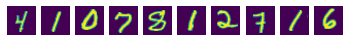

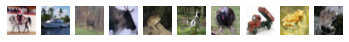

In [ ]:
mnist = {}
mnist["clf"] = {}
mnist["train"] = {}
mnist["test"] = {}
mnist["train"]["x"], mnist["train"]["y"] = get_np_data(
    name="mnist", split="train[:1000]", binary_labels=True
)
mnist["test"]["x"], mnist["test"]["y"] = get_np_data(
    name="mnist", split="test[:200]", binary_labels=True
)
mnist["train"]["xf"] = jnp.reshape(mnist["train"]["x"],
  (mnist["train"]["x"].shape[0], -1))
mnist["test"]["xf"] = jnp.reshape(mnist["test"]["x"],
  (mnist["test"]["x"].shape[0], -1))

cifar10 = {}
cifar10["clf"] = {}
cifar10["train"] = {}
cifar10["test"] = {}
cifar10["train"]["x"], cifar10["train"]["y"] = get_np_data(
    name="cifar10", split="train[:1000]", binary_labels=True
)
cifar10["test"]["x"], cifar10["test"]["y"] = get_np_data(
    name="cifar10", split="test[:200]", binary_labels=True
)
cifar10["train"]["xf"] = jnp.reshape(cifar10["train"]["x"],
  (cifar10["train"]["x"].shape[0], -1))
cifar10["test"]["xf"] = jnp.reshape(cifar10["test"]["x"],
  (cifar10["test"]["x"].shape[0], -1))

plot_sample_data(mnist["train"]["x"], 10, flat=False)
plot_sample_data(cifar10["train"]["x"], 10, flat=False)

In [ ]:
%%time
def clf_test_acc(clf, X, Y):
  return jnp.count_nonzero(Y == clf.predict(X)) / len(Y)

mnist["clf"]["rbf"] = svm.SVC(C=3, gamma="scale") \
  .fit(mnist["train"]["xf"], mnist["train"]["y"])
print(mnist["clf"]["rbf"])
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["rbf"],
  mnist["test"]["xf"], mnist["test"]["y"])))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.925
(525, 784)
CPU times: user 779 ms, sys: 2.81 ms, total: 782 ms
Wall time: 781 ms


In [ ]:
%%time
mnist["clf"]["linear"] = svm.SVC(C=3, kernel="linear") \
  .fit(mnist["train"]["xf"], mnist["train"]["y"])
print(mnist["clf"]["linear"])
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["linear"],
  mnist["test"]["xf"], mnist["test"]["y"])))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.73
(324, 784)
CPU times: user 779 ms, sys: 0 ns, total: 779 ms
Wall time: 777 ms


In [ ]:
%%time
mnist["clf"]["poly-4"] = svm.SVC(C=3, degree=4, kernel="poly") \
  .fit(mnist["train"]["xf"], mnist["train"]["y"])
print(mnist["clf"]["poly-4"])
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["poly-4"],
  mnist["test"]["xf"], mnist["test"]["y"])))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.9
(493, 784)
CPU times: user 712 ms, sys: 851 µs, total: 713 ms
Wall time: 711 ms


In [ ]:
%%time
def kernel_laplacian(A, B):
  return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.01)
mnist["clf"]["laplacian"] = svm.SVC(C=3, kernel=kernel_laplacian) \
  .fit(mnist["train"]["xf"], mnist["train"]["y"])
print(mnist["clf"]["laplacian"])
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["laplacian"],
  mnist["test"]["xf"], mnist["test"]["y"])))
mnist["clf"]["laplacian"].support_vectors_ = \
  np.take(mnist["train"]["xf"], mnist["clf"]["laplacian"].support_, axis=0)
print("support-vector-shape: {}".format(
  mnist["clf"]["laplacian"].support_vectors_.shape))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_laplacian at 0x7fca405619d8>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
test-accuracy: 0.915
support-vector-shape: (638, 784)
CPU times: user 722 ms, sys: 0 ns, total: 722 ms
Wall time: 720 ms


In [ ]:
%%time
cifar10["clf"]["rbf"] = svm.SVC(C=3, gamma="scale") \
  .fit(cifar10["train"]["xf"], cifar10["train"]["y"])
print(cifar10["clf"]["rbf"])
print("test-accuracy: {}".format(clf_test_acc(cifar10["clf"]["rbf"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("support-vector-shape: {}".format(
  cifar10["clf"]["laplacian"].support_vectors_.shape))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.69
support-vector-shape: (1000, 3072)
CPU times: user 5.18 s, sys: 5.69 ms, total: 5.19 s
Wall time: 5.18 s


In [ ]:
%%time
cifar10["clf"]["linear"] = svm.SVC(C=3, kernel="linear") \
  .fit(cifar10["train"]["xf"], cifar10["train"]["y"])
print(cifar10["clf"]["linear"])
print("test-accuracy: {}".format(clf_test_acc(cifar10["clf"]["linear"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("support-vector-shape: {}".format(
  cifar10["clf"]["laplacian"].support_vectors_.shape))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.52
support-vector-shape: (1000, 3072)
CPU times: user 5.92 s, sys: 20.5 ms, total: 5.94 s
Wall time: 5.94 s


In [ ]:
%%time
cifar10["clf"]["poly-4"] = svm.SVC(C=3, degree=4, kernel="poly") \
  .fit(cifar10["train"]["xf"], cifar10["train"]["y"])
print(cifar10["clf"]["poly-4"])
print("test-accuracy: {}".format(clf_test_acc(cifar10["clf"]["poly-4"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("support-vector-shape: {}".format(
  cifar10["clf"]["laplacian"].support_vectors_.shape))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
test-accuracy: 0.62
support-vector-shape: (1000, 3072)
CPU times: user 5.45 s, sys: 7.09 ms, total: 5.46 s
Wall time: 5.45 s


In [ ]:
%%time
def kernel_laplacian(A, B):
  return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.01)
cifar10["clf"]["laplacian"] = svm.SVC(C=3, kernel=kernel_laplacian) \
  .fit(cifar10["train"]["xf"], cifar10["train"]["y"])
print(cifar10["clf"]["laplacian"])
print("test-accuracy: {}".format(clf_test_acc(cifar10["clf"]["laplacian"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
cifar10["clf"]["laplacian"].support_vectors_ = \
  np.take(cifar10["train"]["xf"], cifar10["clf"]["laplacian"].support_, axis=0)
print("support-vector-shape: {}".format(
  cifar10["clf"]["laplacian"].support_vectors_.shape))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_laplacian at 0x7fc9b3a10158>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
test-accuracy: 0.6
support-vector-shape: (1000, 3072)
CPU times: user 2.76 s, sys: 1.7 ms, total: 2.76 s
Wall time: 2.76 s


In [ ]:
def csvc_kernel(clf, X):
  if clf.get_params()["kernel"] == "linear":
    return jnp.dot(clf.support_vectors_, X.T)
  elif clf.get_params()["kernel"] == "rbf":
    return jnp.exp(-clf._gamma * jax.vmap(lambda x1: jax.vmap(
      lambda y1: jnp.sum((x1 - y1) ** 2))(X))(clf.support_vectors_))
  elif clf.get_params()["kernel"] == "poly":
    # Poly-4.
    raise NotImplementedError()
  else:
    # Laplacian.
    return jnp.exp(-0.01 * jax.vmap(lambda x1: jax.vmap(
      lambda y1: jnp.sum(jnp.abs(x1 - y1)))(X))(clf.support_vectors_))

def csvc_decision_function(clf, X):
  k = csvc_kernel(clf, X)
  return jnp.matmul(clf.dual_coef_, k)[0] + clf.intercept_

def csvc_decision_function_single(clf, x):
  k = csvc_kernel(clf, jnp.array([x]))
  return (jnp.matmul(clf.dual_coef_, k)[0] + clf.intercept_)[0]

def csvc_decision_function_grad(clf, X):
  csvc_decision_function_single_grad = jax.grad(csvc_decision_function_single, 1)
  return jax.vmap(lambda x1: csvc_decision_function_single_grad(clf, x1))(X)

def csvc_predict(clf, X):
  return (csvc_decision_function(clf, X) > 0).astype(np.int)

In [ ]:
# Built-in.
print(mnist["clf"]["rbf"].decision_function(mnist["train"]["xf"][:10]))
print(mnist["clf"]["rbf"].predict(mnist["train"]["xf"][:10]))

# CSVC.
print(csvc_decision_function(mnist["clf"]["rbf"], mnist["train"]["xf"][:10]))
print(csvc_predict(mnist["clf"]["rbf"], mnist["train"]["xf"][:10]))

[-1.00035606 -1.2212169  -1.02843178  1.21851642  0.99994354 -1.37846963
 -1.18944533  1.00001557 -1.24741479  1.66316382]
[0 0 0 1 1 0 0 1 0 1]
[-1.00035606 -1.2212169  -1.02843178  1.21851642  0.99994354 -1.37846963
 -1.18944533  1.00001557 -1.24741479  1.66316382]
[0 0 0 1 1 0 0 1 0 1]


In [ ]:
# Built-in.
print(mnist["clf"]["linear"].decision_function(mnist["train"]["xf"][:10]))
print(mnist["clf"]["linear"].predict(mnist["train"]["xf"][:10]))

# CSVC.
print(csvc_decision_function(mnist["clf"]["linear"], mnist["train"]["xf"][:10]))
print(csvc_predict(mnist["clf"]["linear"], mnist["train"]["xf"][:10]))

[-0.99971715 -3.54627646 -0.99980105  1.50687166  3.92473507 -1.55803737
 -3.90637161  2.3499579  -1.84496018  3.53057822]
[0 0 0 1 1 0 0 1 0 1]
[-0.99971715 -3.54627646 -0.99980105  1.50687166  3.92473507 -1.55803737
 -3.90637161  2.3499579  -1.84496018  3.53057822]
[0 0 0 1 1 0 0 1 0 1]


In [ ]:
# Built-in.
print(mnist["clf"]["poly-4"].decision_function(mnist["train"]["xf"][:10]))
print(mnist["clf"]["poly-4"].predict(mnist["train"]["xf"][:10]))

# CSVC.
print(csvc_decision_function(mnist["clf"]["poly-4"], mnist["train"]["xf"][:10]))
print(csvc_predict(mnist["clf"]["poly-4"], mnist["train"]["xf"][:10]))

[-0.90840307 -1.0520111  -1.7619367   1.52533162  0.99973344 -2.08323005
 -1.38842494  1.00001971 -1.35749863  4.03821781]
[0 0 0 1 1 0 0 1 0 1]


NotImplementedError: ignored

In [ ]:
# Built-in.
print(mnist["clf"]["laplacian"].decision_function(mnist["train"]["xf"][:10]))
print(mnist["clf"]["laplacian"].predict(mnist["train"]["xf"][:10]))

# CSVC.
print(csvc_decision_function(mnist["clf"]["laplacian"], mnist["train"]["xf"][:10]))
print(csvc_predict(mnist["clf"]["laplacian"], mnist["train"]["xf"][:10]))

[-0.99988055 -1.23739416 -0.99956179  1.03402653  0.99996759 -1.18255285
 -1.0370229   0.99971965 -1.21801776  1.55539195]
[0 0 0 1 1 0 0 1 0 1]
[-0.99988055 -1.23739416 -0.99956179  1.03402653  0.99996759 -1.18255285
 -1.0370229   0.99971965 -1.21801776  1.55539195]
[0 0 0 1 1 0 0 1 0 1]


In [ ]:
def adv_pgd(X, Y, grad_f, eps, eps_norm, steps, step_size, step_norm):
  res = np.copy(X)
  for step in range(steps):
    res_grad = grad_f(res)
    res_grad_Y = res_grad * (Y * -2 + 1).reshape((-1, 1))

    # Step.
    if step_norm == np.inf:
      res_delta = np.sign(res_grad_Y) * step_size
    else:
      res_delta = sklearn.preprocessing.normalize(
        res_grad_Y, norm="l" + str(step_norm), axis=1) * step_size
    res += res_delta

    # Project.
    if eps_norm == np.inf:
      res = np.clip(res, X - eps, X + eps)
    else:
      mask = res - X
      res = X + eps * sklearn.preprocessing.normalize(
        mask, norm="l" + str(eps_norm), axis=1)
    res = np.clip(res, 0, 1)
  
  return res

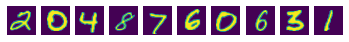

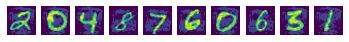

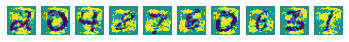

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
[3.74722507 3.79111584 3.80680037 3.47630326 3.60963148 3.57735113
 3.9175227  3.47574319 3.62959309 3.582541  ]
CPU times: user 53.2 s, sys: 4.42 s, total: 57.7 s
Wall time: 28.2 s


In [ ]:
%%time
mnist["test"]["pert"] = {}
mnist["test"]["pert"]["rbf"] = {}
mnist["test"]["pert"]["rbf"]["x"] = adv_pgd(mnist["test"]["xf"],
  mnist["test"]["y"],
  lambda X: csvc_decision_function_grad(mnist["clf"]["rbf"], X),
  0.2, np.inf, 30, 0.015, np.inf)
mnist["test"]["pert"]["rbf"]["diff"] = mnist["test"]["pert"]["rbf"]["x"] - \
  mnist["test"]["xf"]

plot_sample_data(mnist["test"]["xf"], 10)
plot_sample_data(mnist["test"]["pert"]["rbf"]["x"], 10)
plot_sample_data(mnist["test"]["pert"]["rbf"]["diff"], 10)
print(np.max(np.abs(mnist["test"]["pert"]["rbf"]["diff"][:10]), axis=1))
print(np.linalg.norm(mnist["test"]["pert"]["rbf"]["diff"][:10], axis=1))

In [ ]:
%%time
# Built-in.
print(mnist["clf"]["rbf"].decision_function(mnist["test"]["xf"][:10]))
print(mnist["clf"]["rbf"].predict(mnist["test"]["xf"][:10]))
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["rbf"],
  mnist["test"]["xf"], mnist["test"]["y"])))

# Adversarial.
print(mnist["clf"]["rbf"].decision_function(
  mnist["test"]["pert"]["rbf"]["x"][:10]))
print(mnist["clf"]["rbf"].predict(
  mnist["test"]["pert"]["rbf"]["x"][:10]))
print("test-accuracy: {}".format(clf_test_acc(mnist["clf"]["rbf"],
  mnist["test"]["pert"]["rbf"]["x"], mnist["test"]["y"])))

[-0.59575778 -0.74737197 -1.29749949  0.63710384  1.41824148  1.30168883
 -1.40530141  0.87842047 -0.24945856 -1.18739962]
[0 0 0 1 1 1 0 1 0 0]
test-accuracy: 0.925
[ 1.59629163  0.9906815   1.24266914 -1.47580922 -0.74034125 -0.51695428
  0.69716797 -1.18146334  1.76700697  1.87818407]
[1 1 1 0 0 0 1 0 1 1]
test-accuracy: 0.0
CPU times: user 275 ms, sys: 1.08 ms, total: 277 ms
Wall time: 273 ms


In [ ]:
def pgd_eval(clf, X, Y, eps, norm, steps, step_size, samples=10, channels=1):
  pert = adv_pgd(X, Y,
    lambda X: csvc_decision_function_grad(clf, X),
    eps, norm, steps, step_size, norm)
  diff = pert - X
  plot_sample_data(X, samples, True, channels)
  plot_sample_data(pert, samples, True, channels)
  plot_sample_data(diff, samples, True, channels)
  print("l_inf(diff): {}; l_2(diff): {}".format(
    np.max(np.abs(diff[:samples])),
    np.max(np.linalg.norm(diff[:10], axis=1))))
  return clf_test_acc(clf, pert, Y)

--------
mnist-rbf-test-acc: 0.925


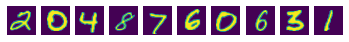

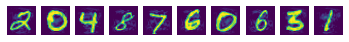

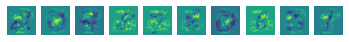

l_inf(diff): 0.4206042377291266; l_2(diff): 1.9992458363572438
mnist-rbf-2-2-30-0.15: 0.155


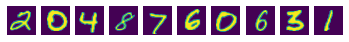

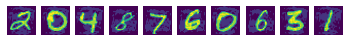

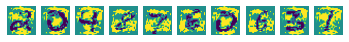

l_inf(diff): 0.15000000000000002; l_2(diff): 3.0346812489260917
mnist-rbf-0.2-inf-30-0.015: 0.13
--------
mnist-linear-test-acc: 0.73


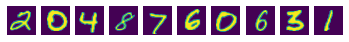

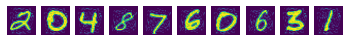

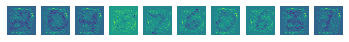

l_inf(diff): 0.5176470588235295; l_2(diff): 1.998125520091022
mnist-linear-2-2-30-0.15: 0.0


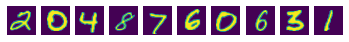

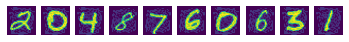

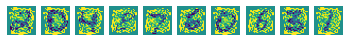

l_inf(diff): 0.15000000000000002; l_2(diff): 2.8101357164909384
mnist-linear-0.2-inf-30-0.015: 0.0
--------
mnist-laplacian-test-acc: 0.915


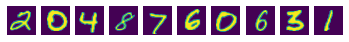

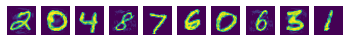

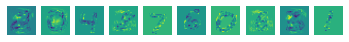

l_inf(diff): 0.7145414837577578; l_2(diff): 1.9997865269474673
mnist-laplacian-2-2-30-0.15: 0.31


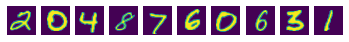

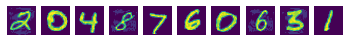

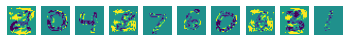

l_inf(diff): 0.15000000000000002; l_2(diff): 2.500898473689337
mnist-laplacian-0.2-inf-30-0.015: 0.59
CPU times: user 5min 13s, sys: 39.4 s, total: 5min 53s
Wall time: 2min 50s


In [ ]:
%%time
print("--------")
print("mnist-rbf-test-acc: {}".format(clf_test_acc(mnist["clf"]["rbf"],
  mnist["test"]["xf"], mnist["test"]["y"])))
print("mnist-rbf-2-2-30-0.15: {}".format(pgd_eval(mnist["clf"]["rbf"],
  mnist["test"]["xf"], mnist["test"]["y"], 2, 2, 30, 0.15)))
print("mnist-rbf-0.2-inf-30-0.015: {}".format(pgd_eval(mnist["clf"]["rbf"],
  mnist["test"]["xf"], mnist["test"]["y"], 0.15, np.inf, 30, 0.015)))

print("--------")
print("mnist-linear-test-acc: {}".format(clf_test_acc(mnist["clf"]["linear"],
  mnist["test"]["xf"], mnist["test"]["y"])))
print("mnist-linear-2-2-30-0.15: {}".format(pgd_eval(mnist["clf"]["linear"],
  mnist["test"]["xf"], mnist["test"]["y"], 2, 2, 30, 0.15)))
print("mnist-linear-0.2-inf-30-0.015: {}".format(pgd_eval(mnist["clf"]["linear"],
  mnist["test"]["xf"], mnist["test"]["y"], 0.15, np.inf, 30, 0.015)))

# print("--------")
# print("mnist-poly-4-test-acc: {}".format(clf_test_acc(mnist["clf"]["poly-4"],
#   mnist["test"]["xf"], mnist["test"]["y"])))
# print("mnist-poly-4-2-2-30-0.15: {}".format(pgd_eval(mnist["clf"]["poly-4"],
#   mnist["test"]["xf"], mnist["test"]["y"], 2, 2, 30, 0.15)))
# print("mnist-poly-4-0.2-inf-30-0.015: {}".format(pgd_eval(mnist["clf"]["poly-4"],
#   mnist["test"]["xf"], mnist["test"]["y"], 0.15, np.inf, 30, 0.015)))

print("--------")
print("mnist-laplacian-test-acc: {}".format(clf_test_acc(mnist["clf"]["laplacian"],
  mnist["test"]["xf"], mnist["test"]["y"])))
print("mnist-laplacian-2-2-30-0.15: {}".format(pgd_eval(mnist["clf"]["laplacian"],
  mnist["test"]["xf"], mnist["test"]["y"], 2, 2, 30, 0.15)))
print("mnist-laplacian-0.2-inf-30-0.015: {}".format(pgd_eval(mnist["clf"]["laplacian"],
  mnist["test"]["xf"], mnist["test"]["y"], 0.15, np.inf, 30, 0.015)))

--------
cifar10-rbf-test-acc: 0.69


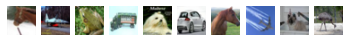

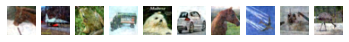

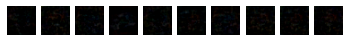

l_inf(diff): 0.17739412047397402; l_2(diff): 2.000000000000001
cifar10-rbf-2-2-30-0.15: 0.025


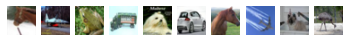

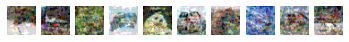

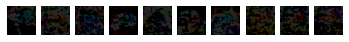

l_inf(diff): 0.15000000000000002; l_2(diff): 7.536504646557429
cifar10-rbf-0.2-inf-30-0.015: 0.0
--------
cifar10-linear-test-acc: 0.52


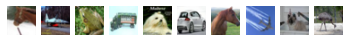

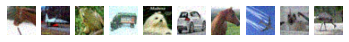

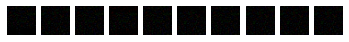

l_inf(diff): 0.14304578775690624; l_2(diff): 1.9999617810417623
cifar10-linear-2-2-30-0.15: 0.0


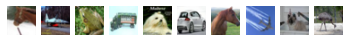

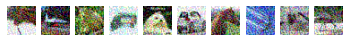

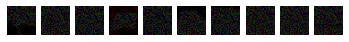

l_inf(diff): 0.15000000000000002; l_2(diff): 8.296238545871024
cifar10-linear-0.2-inf-30-0.015: 0.0
--------
cifar10-laplacian-test-acc: 0.6


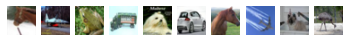

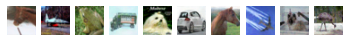

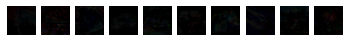

l_inf(diff): 0.1708470909441746; l_2(diff): 2.0000000000000013
cifar10-laplacian-2-2-30-0.15: 0.33


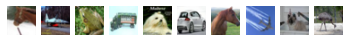

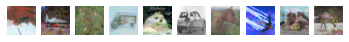

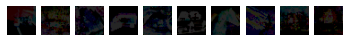

l_inf(diff): 0.15000000000000002; l_2(diff): 7.5347813522963465
cifar10-laplacian-0.2-inf-30-0.015: 0.025
CPU times: user 24min 3s, sys: 45min 15s, total: 1h 9min 19s
Wall time: 37min 20s


In [ ]:
%%time
print("--------")
print("cifar10-rbf-test-acc: {}".format(clf_test_acc(cifar10["clf"]["rbf"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("cifar10-rbf-2-2-30-0.15: {}".format(pgd_eval(cifar10["clf"]["rbf"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 2, 2, 30, 0.15, 10, 3)))
print("cifar10-rbf-0.2-inf-30-0.015: {}".format(pgd_eval(cifar10["clf"]["rbf"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 0.15, np.inf, 30, 0.015, 10, 3)))

print("--------")
print("cifar10-linear-test-acc: {}".format(clf_test_acc(cifar10["clf"]["linear"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("cifar10-linear-2-2-30-0.15: {}".format(pgd_eval(cifar10["clf"]["linear"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 2, 2, 30, 0.15, 10, 3)))
print("cifar10-linear-0.2-inf-30-0.015: {}".format(pgd_eval(cifar10["clf"]["linear"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 0.15, np.inf, 30, 0.015, 10, 3)))

# print("--------")
# print("cifar10-poly-4-test-acc: {}".format(clf_test_acc(cifar10["clf"]["poly-4"],
#   cifar10["test"]["xf"], cifar10["test"]["y"])))
# print("cifar10-poly-4-2-2-30-0.15: {}".format(pgd_eval(cifar10["clf"]["poly-4"],
#   cifar10["test"]["xf"], cifar10["test"]["y"], 2, 2, 30, 0.15)))
# print("cifar10-poly-4-0.2-inf-30-0.015: {}".format(pgd_eval(cifar10["clf"]["poly-4"],
#   cifar10["test"]["xf"], cifar10["test"]["y"], 0.15, np.inf, 30, 0.015)))

print("--------")
print("cifar10-laplacian-test-acc: {}".format(clf_test_acc(cifar10["clf"]["laplacian"],
  cifar10["test"]["xf"], cifar10["test"]["y"])))
print("cifar10-laplacian-2-2-30-0.15: {}".format(pgd_eval(cifar10["clf"]["laplacian"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 2, 2, 30, 0.15, 10, 3)))
print("cifar10-laplacian-0.2-inf-30-0.015: {}".format(pgd_eval(cifar10["clf"]["laplacian"],
  cifar10["test"]["xf"], cifar10["test"]["y"], 0.15, np.inf, 30, 0.015, 10, 3)))